IMPORT LIBRARIES

In [2]:
import warnings
warnings.filterwarnings('ignore')
import cornac
from cornac.data import Reader
from cornac.eval_methods import RatioSplit
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import pickle
import scipy
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import scipy.special as special
import itertools
import random
from openpyxl import Workbook 
import openpyxl 


RUN NEUMF ON RECSYS16 DATASET

In [3]:
def ui_parser(tokens, **kwargs):
    if tokens[2] == '4':
        return [(tokens[0], tokens[1] , 2.0) ]
    
    return [(tokens[0], tokens[1] , 1.0 ) ]

In [4]:

fpath =r".....................................interactions.csv"

reader = Reader()
feedback = reader.read(fpath, parser= ui_parser,skip_lines=8650000, sep='\t')

feed = [(item[0], item[1], item[2]) for item in feedback]    
labels = [item[2] for item in feed]




ratio_split = RatioSplit(
    data=feedback,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=123,
    rating_threshold=0.5,
)



ncf = cornac.models.NeuMF(
    num_factors=10,
    layers=[64, 32, 16, 8],
    act_fn="tanh",
    learner="adam",
    num_epochs=60,
    batch_size=256,
    lr=0.001,
    num_neg=40,
    seed=123,
)


# Instantiate evaluation metrics
ndcg_10 = cornac.metrics.NDCG(k=10)
rec_20=cornac.metrics.Recall(k=20)


models=[ncf]

# Put everything together into an experiment and run it
cornac.Experiment(
    eval_method=ratio_split,
    models=models,
    metrics=[ndcg_10, rec_20],
).run()


rating_threshold = 0.5
exclude_unknowns = True
---
Training data:
Number of users = 13607
Number of items = 80688
Number of ratings = 115191
Max rating = 2.0
Min rating = 1.0
Global mean = 1.2
---
Test data:
Number of users = 5590
Number of items = 13754
Number of ratings = 18456
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 13607
Total items = 80688

[NeuMF] Training started!


  0%|          | 0/60 [00:00<?, ?it/s]


[NeuMF] Evaluation started!


Ranking:   0%|          | 0/5590 [00:00<?, ?it/s]


TEST:
...
      | NDCG@10 | Recall@20 |  Train (s) | Test (s)
----- + ------- + --------- + ---------- + --------
NeuMF |  0.2137 |    0.3900 | 14740.3663 | 357.2478



In [5]:
data_test = ratio_split.test_set.uir_tuple

labels = data_test[2]

#make it binary
labels[labels<2] = 1
labels[labels>=2] = 0

NeuMF(UJ)
0.6963633410989756


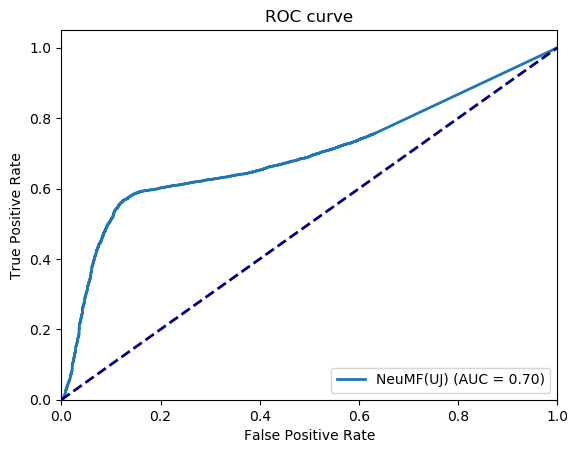

NeuMF(UJ)
0.9067508120979682


<Figure size 640x480 with 0 Axes>

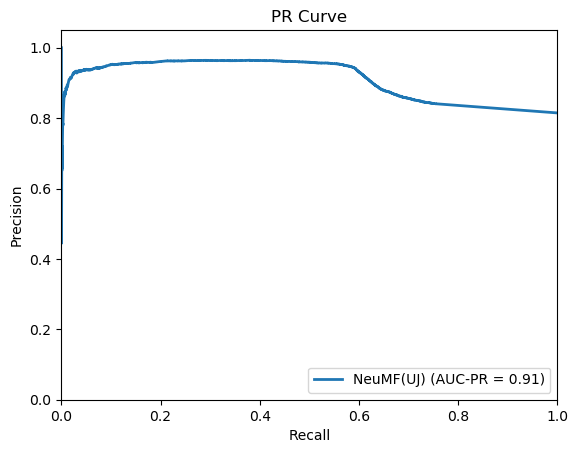

<Figure size 640x480 with 0 Axes>

In [6]:
#caluclate ROC and PR and plot

A = len(models)
scores_all = np.zeros((len(labels),A))
scores=np.zeros((len(labels),A))
for i in range(A):
    s = np.zeros(len(labels))
    #get users from data_test and predict score
    for j in range(data_test[0].shape[0]):
        user = data_test[0][j]
        item = data_test[1][j]
        s[j] = models[i].score(user, item) 
        
    scores[:,i]=s
    s = s / max(s) #make it from 0-1
    scores_all[:,i]=s
    
np.save('scores.npy',scores_all)

plt.figure()
lw = 2
for i in range(A):    
    fpr, tpr, _ = roc_curve(labels, scores_all[:,i])
    roc_auc = auc(fpr, tpr)    
    
    if models[i].name=='NeuMF':
        models[i].name='NeuMF(UJ)'
        
    print(models[i].name)
    print(roc_auc)
        
    plt.plot(fpr, tpr, 
             lw=lw, label= models[i].name + ' (AUC = %0.2f)' % roc_auc)

    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title= 'ROC curve'
plt.title(title)
plt.legend(loc="lower right")
plt.show()
plt.savefig(title + '.png')
    

plt.figure()
lw = 2
for i in range(A):    
    pr, rec, thr = precision_recall_curve(labels, scores_all[:,i] )
    avg_pr = average_precision_score(labels, scores_all[:,i])
    
    print(models[i].name)
    print(avg_pr)
    
    
    plt.plot(rec, pr, 
             lw=lw, label=models[i].name + ' (AUC-PR = %0.2f)' % avg_pr)
    
title = 'PR curve'
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig(title + '.png')

DEFINE AUXILIARY FUNCTIONS

In [7]:
def KLD(D1,D2):
    a = np.asarray(D1, dtype=np.float)
    b = np.asarray(D2, dtype=np.float)

    return np.sum(np.where(a != 0 , a * np.log((a +0.00001)/(b+0.00001)), 0))

def NDKL(df,p):
    Z = np.sum(1/(np.log2(np.arange(1,11)+1)))
    total=0

    for i in range(1,11): 
        value=df[:i].value_counts(normalize = True)
        value=value.to_dict()
        D1=[]
        for j in range(len(p)):
            if j in value.keys():
                D1.append(value[j])
            else:
                D1.append(0)
        total=total+(1/math.log2(i+1)) * KLD(D1,p)

    return (1/Z)*total

In [8]:
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0

def ndcg_at_k(df, k, method=0):
    r=list(df)
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [9]:
def kendall_top_k(a,b,k=None,p=0): #zero is equal 1 is max distance, compare with 1-scipy.stats.kendalltau(a,b)/2+1/2
    """
    kendall_top_k(np.array,np.array,k,p)
    This function generalise kendall-tau as defined in [1] Fagin, Ronald, Ravi Kumar, and D. Sivakumar. "Comparing top k lists." SIAM Journal on Discrete Mathematics 17.1 (2003): 134-160.
    It returns a distance: 0 for identical (in the sense of top-k) lists and 1 if completely different.

    Example:
        Simply call it with two same-length arrays of ratings (or also rankings), length of the top elements k (default is the maximum length possible), and p (default is 0, see [1]) as parameters:

            $ a = np.array([1,2,3,4,5])
            $ b = np.array([5,4,3,2,1])
            $ kendall_top_k(a,b,k=4)
    """
    
    a=list(a.values())
    a=np.array(a)
    #print(a)
    b=list(b.values())
    b=np.array(b)
    #print(b)

    if k is None:
        k = len(a)
    if len(a) != len(b):
        raise NameError('The two arrays need to have same lengths')
    k = min(k,len(a))
    a_top_k = np.argpartition(a,-k)[-k:]
    b_top_k = np.argpartition(b,-k)[-k:]
    common_items = np.intersect1d(a_top_k,b_top_k)
    only_in_a = np.setdiff1d(a_top_k, common_items)
    only_in_b = np.setdiff1d(b_top_k, common_items)
    kendall = (1 - (stats.kendalltau(a[common_items], b[common_items])[0]/2+0.5)) * (common_items.size**2) #case 1
    if np.isnan(kendall): # degenerate case with only one item (not defined by Kendall)
        kendall = 0
    for i in common_items: #case 2
        for j in only_in_a:
            if a[i] < a[j]:
                kendall += 1
        for j in only_in_b:
            if b[i] < b[j]:
                kendall += 1
    kendall += 2*p * special.binom(k-common_items.size,2)     #case 4
    kendall /= ((only_in_a.size + only_in_b.size + common_items.size)**2 ) #normalization
    return kendall

In [10]:
def infeasibleIndexBelowMin(df,p):
    
    """ Params: df = dataFrame for Ranked List, a= No of Values of Protected Attribute
                desired_p = desired proportion of ai's (Array){Provisioned for Later Modification}
                k initial value need to set(default=10)
    
    """
    
    data = df[:10]
    a=len(p)
    desired_p = p
    tao_r = 10
    infeasibleFlag = False
    InfIndex_tao_r = 0
    InfCount_tao_r = 0
    
    
    for k in range(1,tao_r):
        data_temp_k = data[:k]
        infeasibleFlag = False
        for i in range(a):
            desired_p_ai = desired_p[i]
            observed_count_ai = len(data_temp_k[data_temp_k==i])
            desired_count_ai= math.floor(desired_p_ai*k)
            if observed_count_ai < desired_count_ai:
                infeasibleFlag = True
                ## Increment Infeasible Count
                InfCount_tao_r += 1
                
        ## Increment Infeasible Index
        if infeasibleFlag == True:
            InfIndex_tao_r += 1
    if InfIndex_tao_r > 99:
        print(f'Error at {a} and it is: {InfIndex_tao_r}')
    Infeasible_Return_array = [InfIndex_tao_r, InfCount_tao_r]
    return InfIndex_tao_r

In [11]:
def infeasibleIndexBelowMax(df,p):
    
    """ Params: df = dataFrame for Ranked List, a= No of Values of Protected Attribute
                desired_p = desired proportion of ai's (Array){Provisioned for Later Modification}
                k initial value need to set(default=10)
    
    """
    
    data = df[:10]
    a=len(p)
    desired_p = p
    tao_r = 10
    infeasibleFlag = False
    InfIndex_tao_r = 0
    InfCount_tao_r = 0
    
    
    for k in range(1,tao_r):
        data_temp_k = data[:k]
        infeasibleFlag = False
        for i in range(a):
            desired_p_ai = desired_p[i]
            observed_count_ai = len(data_temp_k[data_temp_k==i])
            desired_count_ai= math.ceil(desired_p_ai*k)
            if observed_count_ai > desired_count_ai:
                infeasibleFlag = True
                ## Increment Infeasible Count
                InfCount_tao_r += 1
                
        ## Increment Infeasible Index
        if infeasibleFlag == True:
            InfIndex_tao_r += 1
    if InfIndex_tao_r > 99:
        print(f'Error at {a} and it is: {InfIndex_tao_r}')
    Infeasible_Return_array = [InfIndex_tao_r, InfCount_tao_r]
    return InfIndex_tao_r
    

READ JOBS INFO

In [12]:

item_info = pd.read_table(r"....................................items.csv", sep='\t',skiprows=1,
                        engine='python', names=['ItemId','title','career_level','discipline_id','industry_id','country'
                                                ,'region','latitude','longitude'
                                                ,'employment','tags','created_at' ,'active_during_test'])

item_info=item_info.drop("created_at", axis=1)
item_info=item_info.drop("active_during_test", axis=1)
item_info=item_info.drop("tags",axis=1)
item_info=item_info.drop("title", axis=1)
item_info=item_info.drop("latitude",axis=1)
item_info=item_info.drop("longitude",axis=1)
item_info.head()

,ItemId,career_level,discipline_id,industry_id,country,region,employment
0,19,3.0,18,15,ch,0,1
1,116,2.0,20,22,de,1,2
2,140,3.0,12,15,at,0,2
3,161,3.0,15,21,de,0,1
4,190,3.0,14,15,de,6,1


In [13]:
jobs=item_info.to_numpy()
print(jobs[0])

[19 3.0 18 15 'ch' 0 1]


READ USERS INFO

In [14]:
user_info = pd.read_table(r"C:users.csv", sep='\t',skiprows=1,
                        engine='python', names=['id','jobroles','career_level','discipline_id','industry_id','country'
                                                ,'region','experience_n_entries_class','experience_years_experience',
                                                'experience_years_in_current','edu_degree','edu_fieldofstudies'])


user_info=user_info.drop("experience_n_entries_class", axis=1)
user_info=user_info.drop("experience_years_in_current", axis=1)
user_info=user_info.drop("edu_degree",axis=1)
user_info=user_info.drop("edu_fieldofstudies", axis=1)
user_info.head()

,id,jobroles,career_level,discipline_id,industry_id,country,region,experience_years_experience
0,4,2424638,3.0,0,8,de,10.0,5.0
1,7,"3287640,524375",0.0,3,8,de,1.0,0.0
2,9,3418410,2.0,0,0,de,0.0,2.0
3,13,3079492,NaN,0,0,de,2.0,2.0
4,19,3378061,4.0,0,0,de,0.0,4.0


In [15]:
users=user_info.to_numpy()
print(users[0])

[4 '2424638' 3.0 0 8 'de' 10.0 5.0]


MATCH RATINGS WITH USERS AND JOBS INFO

In [18]:
score_neumf=scores_all[:]



test_data = ratio_split.test_set.uir_tuple
iid = ratio_split.global_iid_map
uid = ratio_split.global_uid_map

user_list=[]
unique_users=[]
neumf_ratings=[]




for k in range (test_data[1].shape[0]):
    #print(test_data[1].shape[0]-k)
    user_state,user_country,job_state,job_country=[],[],[],[]
    for n in range (len(jobs)):
        if (str(jobs[n][0]) in iid) and (iid[str(jobs[n][0])] == test_data[1][k]) :
            job_state=jobs[n][2]
            job_country=jobs[n][5]
            break
    
    for n in range (len(users)):
        if (str(users[n][0]) in uid) and (uid[str(users[n][0])] == test_data[0][k]) :
            user_state=users[n][3]
            user_country=users[n][6]
            break
    
    
    job = test_data[1][k] 
    user = test_data[0][k]
    
    rate_neumf = score_neumf[k]
   
    user_list.append(user)
    
        
    
    neumf_ratings.append((job,user,rate_neumf,user_state,user_country,job_state,job_country))
             
for user in user_list:
    if user not in unique_users:
        unique_users.append(user)

AUXILIARY FUNCTIONS TO CREATE DATA FOR RERANKING ALGOS (disciple_id AND region MATCHED ATTRIBUTES)

In [19]:
def experiment (user_index,k_max,ratings):
    scores={}
    for i in range(4):
        scoresgen=[]
        ind0,ind1=0,0
        if i==0:
            ind0=0
            ind1=0
        elif i==1:
            ind0=0
            ind1=1
        elif i==2: 
            ind0=1
            ind1=0
        elif i==3:
            ind0=1
            ind1=1
        
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 3 :
            
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,1]
                    scoresgen.append(score)
             
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 2 and  ratings[m][6] != ratings[m][4]:
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,0]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 1 and ratings[m][5] != ratings[m][3]:
                
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,1]
                    scoresgen.append(score)
         
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,ind0,ind1]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

In [20]:
def experiment1 (user_index,k_max,ratings):
    scores={}
    for j in range(4):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind0=0
            ind1=0
            i=0
        elif j==1:
            ind0=0
            ind1=1
            i=1
        elif j==2: 
            ind0=1
            ind1=0
            i=2
        elif j==3:
            ind0=1
            ind1=1
            i=3
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 3 :
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,1,i]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 2 and  ratings[m][6] != ratings[m][4]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,0,i]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 1 and ratings[m][5] != ratings[m][3]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,1,i]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                   
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0,i]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,ind0,ind1,i]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

In [21]:
def experiment2 (user_index,k_max,ratings):
    scores={}
    for j in range(4):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind0=0
            ind1=0
            i=0
        elif j==1:
            ind0=0
            ind1=1
            i=1
        elif j==2: 
            ind0=1
            ind1=0
            i=2
        elif j==3:
            ind0=1
            ind1=1
            i=3
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 3 :
                
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                
                    score=[ratings[m][2], 1,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 2 and  ratings[m][6] != ratings[m][4]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                
                    score=[ratings[m][2], 1,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 1 and ratings[m][5] != ratings[m][3]:
                   
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    
                    score=[ratings[m][2], 0,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                
                    score=[ratings[m][2], 0,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,ind0,ind1,i, ratings[m][3],ratings[m][4],0]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

AUXILIARY FUNCTION TO CREATE DATA FOR RERANKING ALGOS (discipline_id MATCHED ATTRIBUTE)

In [22]:
def experiment11 (user_index,k_max,ratings):
    scores={}
    for j in range(2):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind0=0
            i=0
        elif j==1:
            ind0=1
            i=1
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 1 :
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,1,i]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 1 and  ratings[m][6] != ratings[m][4]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,0,i]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 1 and ratings[m][5] != ratings[m][3]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,1,i]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                  
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0,i]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,ind0,0,i]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

In [23]:
def experiment111 (user_index,k_max,ratings):
    scores={}
    for j in range(2):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind0=0
            i=0
        elif j==1:
            ind0=1
            i=1
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 1 :
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 1 and  ratings[m][6] != ratings[m][4]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 1 and ratings[m][5] != ratings[m][3]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                  
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,ind0,0,i,ratings[m][3],ratings[m][4],0]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

AUXILIARY FUNCTION TO CREATE DATA FOR RERANKING ALGOS (region MATCHED ATTRIBUTE)

In [24]:
def experiment12 (user_index,k_max,ratings):
    scores={}
    for j in range(2):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind1=0
            i=0
        elif j==1:
            ind1=1
            i=1
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 1 :
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,1,i]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 0 and  ratings[m][6] != ratings[m][4]:
                   
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,0,i]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 0 and ratings[m][5] != ratings[m][3]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,1,i]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0,i]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,0,ind1,i]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

In [25]:
def experiment121 (user_index,k_max,ratings):
    scores={}
    for j in range(2):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind1=0
            i=0
        elif j==1:
            ind1=1
            i=1
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 1 :
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 0 and  ratings[m][6] != ratings[m][4]:
                   
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 0 and ratings[m][5] != ratings[m][3]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,0,ind1,i,ratings[m][3],ratings[m][4],0]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

AUXILIARY FUNCTION TO COMPUTE METRICS

In [26]:
def xxxNDKL(algo,pA,pB):


    k_max=10 # top-4 αποτελεσμαάτων

    
    table=algo


    dataA={}
    dataB={}
    dataAB={}
    AlgoA={}
    AlgoB={} 
    AlgoAB={}
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    rankedAttListAB=[]
    rankedScoreListAB=[]
    A,B, AB =[],[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
    
    for i in range (4):  # αρχικοποίηση πινάκα και set για το attribute group ages
        AB.append(0)
        for j in range (k_max):
            dataAB[(i,j)]=0.0
    

    for k in range (0,4):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων 
        for i in range(0,k_max):
            for j in range(len(pA)):
                if table[(k,i)][1]==j:
                    dataA[(j,A[j])]=table[(k,i)][0]
                    rankedAttListA.append(j)
                    rankedScoreListA.append(table[(k,i)][0])
                    A[j]+=1
    rankedScoreListA.sort(reverse=True) 
    rankedAttListA=[x for _,x in sorted(zip(rankedScoreListA,rankedAttListA), reverse=True)]
        
    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for k in range(0,4):
        for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
            for j in range (len(pB)):
                if table[(k,i)][2]==j:
                    dataB[(j,B[j])]=table[(k,i)][0]
                    rankedAttListB.append(j)
                    rankedScoreListB.append(table[(k,i)][0])
                    B[j]+=1    
    rankedScoreListB.sort(reverse=True) 
    rankedAttListB=[x for _,x in sorted(zip(rankedScoreListB,rankedAttListB), reverse=True)] 
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
    #print(AlgoA[:10])
    #print(AlgoB[:10])
    
    
    for k in range(0,4):
        for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
            for j in range (4):
                if table[(k,i)][3]==j:
                    dataAB[(j,AB[j])]=table[(k,i)][0]
                    rankedAttListAB.append(j)
                    rankedScoreListAB.append(table[(k,i)][0])
                    AB[j]+=1    
    rankedScoreListAB.sort(reverse=True) 
    rankedAttListAB=[x for _,x in sorted(zip(rankedScoreListAB,rankedAttListAB), reverse=True)] 
        
    AlgoAB=pd.DataFrame(list(zip(rankedAttListAB, rankedScoreListAB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   

   
    
    xNDKLold = NDKL(AlgoA['ai'][:10],pA)+NDKL(AlgoB['ai'][:10],pB) 
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    return xNDKLold , NDKL(AlgoA['ai'][:10],pA), NDKL(AlgoB['ai'][:10],pB), NDKL(AlgoAB['ai'][:10],[1/16,3/16,3/16,9/16]),infeasibleIndexBelowMin(AlgoA['ai'],pA),infeasibleIndexBelowMin(AlgoB['ai'],pB),infeasibleIndexBelowMin(AlgoAB['ai'],[1/16,3/16,3/16,9/16]),infeasibleIndexBelowMax(AlgoA['ai'],pA),infeasibleIndexBelowMax(AlgoB['ai'],pB),infeasibleIndexBelowMax(AlgoAB['ai'],[1/16,3/16,3/16,9/16])


DETGREEDY ALGORITHM

In [27]:
def DetGreedy(data,p,k_max):
    rankedAttList = [] 
    rankedScoreList = []
    counts={}
    for i in range(len(p)):
        counts[i]=0
    for k in range(1,k_max+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        #print("belowMinSet:",belowMin)
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        #print("belowMaxSet:",belowMax)
        s={}
        if len(belowMin) != 0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        else:
            for i in belowMax:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        #print("nextAtt:",nextAtt)   
        rankedAttList.append(nextAtt)
        #print("rankedAttList:",rankedAttList)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])][0])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])

In [28]:
def DetGreedy1(data,p,k_max):
    rankedAttList = [] 
    rankedScoreList = []
    counts={}
    for i in range(len(p)):
        counts[i]=0
    for k in range(1,k_max+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        #print("belowMinSet:",belowMin)
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        #print("belowMaxSet:",belowMax)
        s={}
        if len(belowMin) != 0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        else:
            for i in belowMax:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        #print("nextAtt:",nextAtt)   
        rankedAttList.append(nextAtt)
        #print("rankedAttList:",rankedAttList)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])

CAL ALGORITHM

In [29]:
# η συνάρτηση παίρνει ως εισόδους την βάση δεδομένων data 
# την πιθανότητα εμφάνισης όλων των attributes σαν ένα attribute π.χ εδ΄ω΄ [1/6,1/6,1/6,1/6,1/6,1/6]
# τα top k_max αποτελέσματα που θέλουμε να προτείνουμε π.χ εδώ top-4
# τους πίνακες συχνοτήτων εμφάνισης κα΄θε  attibute values σε κάθε attibute 

def CAL(data,p,k_max):
    
    # βοηθητικές μεταβλητές
    rankedAttList,rankedScoreList,rankedAttListA,rankedAttListB = [],[],[],[]
    belowMinAtt,belowMaxAtt={},{}
    rankedAttLists=[]
    counts={}
    countsAtt=[]
    xNdkl={}
    att={}
    Algos=[]
    indexes, attindex=[],[]
    sxima=1 
    
    # αρχικοποίηση βοηθητικών δομών δεδομένων
    for i in range(len(p)): 
        Algos.append([])
        sxima*=len(p[i])
        rankedAttLists.append([])
        countsc={}
        for j in range(len(p[i])):
            countsc[j]=0
        countsAtt.append(countsc)
    for k in range(0,k_max+1):
        xNdkl[k]=1000 
    for i in range(sxima):
        counts[i]=0 
    countsAtt.append(counts)
    #print(countsAtt)
    
    # αρχικοποίηση και υπολογισμός του πίνακα των indexes π.χ 1---> 0,1 male 35 years old
    for i in range(sxima):
        indexes.append([])
    for i in range(sxima):
        for j in range(1,len(p)+1):
            indexes[i].append(data[(i,0)][j])
    #print(indexes)
    
    for k in range(1,k_max+1): # για το top-k 
        i=0
        flag=0
        
        for pk in p: # για κάθε attribute  υπολόγισε το belowMax και belowMin
            belowMinAtt[i] = {ai for ai,v in countsAtt[i].items() if v < math.floor(k*pk[ai])}
            #print("belowMinSet:",belowMinAtt)
            belowMaxAtt[i] = {ai for ai,v in countsAtt[i].items() if v >= math.floor(k*pk[ai]) and v <math.ceil(k*pk[ai])}
            #print("belowMaxSet:",belowMaxAtt)
            i+=1

        
        belowMax=[]
        belowMin=[]
        s={}
        for key in belowMinAtt:
            if len(belowMinAtt[key])!=0:
                flag=1
                break
    
              
        if flag==1:   # αν υπάρχει ένα  belowMin από κα΄ποιο  attribute γεμάτο
            for key in belowMinAtt:
                if len(belowMinAtt[key])!=0:
                    belowMaxAtt[key]= belowMinAtt[key] 
            for t in itertools.product(*belowMaxAtt.values()):
                for j in range(len(indexes)):
                    res = (indexes[j]==np.asarray(t)).all()
                    if res==True:
                        belowMin.append(j)  # υπολόγισε το συνολικά belowMin 
            for i in belowMin:
                s[i]=data[(i,countsAtt[len(p)][i])]
            nextAtt = max(s,key=s.get) # και πάρε αυτό με το μέγιστο score
        else: # αλλιώς
            for x in range (len(p)):
                m={}
                for pos in range(k+1,k_max):
                    m[pos]  = [ai for ai,v in countsAtt[x].items() if v < math.floor(pos*p[x][ai])] 
                #print(m) 
                
                for pos in m:
                    if len(m[pos])!=0:
                        belowMaxAtt[x] = list( set(belowMaxAtt[x]).intersection(set(m[pos])) )
                        break     
                    
            #print("here",belowMaxAtt)
            for t in itertools.product(*belowMaxAtt.values()):
                for j in range(len(indexes)):
                    res = (indexes[j]==np.asarray(t)).all()
                    if res==True:
                        belowMax.append(j)   # υπολόγισε το συνολικά belowMax   
            for i in belowMax:
                s[i]=data[(i,countsAtt[len(p)][i])]
            nextAtt = max(s,key=s.get)  # και πάρε αυτό με το μέγιστο score
            
        
        #print("nextAtt:",nextAtt)   
        rankedAttList.append(nextAtt)
        #print("rankedAttList:",rankedAttList)
        rankedScoreList.append(data[(nextAtt,countsAtt[len(p)][nextAtt])][0])
        countsAtt[len(p)][nextAtt]+=1
     
        
        for i in range(len(p)):
            att[i] = indexes[nextAtt][i]
            
     
        xNDKL=0
        for i in range(len(p)):  
            countsAtt[i][att[i]]+=1
            rankedAttLists[i].append(att[i]) 
            Algos[i]=pd.DataFrame(list(zip(rankedAttLists[i], rankedScoreList)),columns =['ai', 'score'])   
            xNDKL+= NDKL(Algos[i]['ai'],p[i])
            
        xNdkl[k]= xNDKL # υπολογισμός του xNDKL 

        
   
    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score']), xNdkl[k]

In [30]:
# η συνάρτηση παίρνει ως εισόδους την βάση δεδομένων data 
# την πιθανότητα εμφάνισης όλων των attributes σαν ένα attribute π.χ εδ΄ω΄ [1/6,1/6,1/6,1/6,1/6,1/6]
# τα top k_max αποτελέσματα που θέλουμε να προτείνουμε π.χ εδώ top-4
# τους πίνακες συχνοτήτων εμφάνισης κα΄θε  attibute values σε κάθε attibute 

def CAL2(data,p,k_max):
    
    # βοηθητικές μεταβλητές
    rankedAttList,rankedScoreList,rankedAttListA,rankedAttListB = [],[],[],[]
    belowMinAtt,belowMaxAtt={},{}
    rankedAttLists=[]
    counts={}
    countsAtt=[]
    xNdkl={}
    att={}
    Algos=[]
    indexes, attindex=[],[]
    sxima=1 
    
    # αρχικοποίηση βοηθητικών δομών δεδομένων
    for i in range(len(p)): 
        Algos.append([])
        sxima*=len(p[i])
        rankedAttLists.append([])
        countsc={}
        for j in range(len(p[i])):
            countsc[j]=0
        countsAtt.append(countsc)
    for k in range(0,k_max+1):
        xNdkl[k]=1000 
    for i in range(sxima):
        counts[i]=0 
    countsAtt.append(counts)
    #print(countsAtt)
    
    # αρχικοποίηση και υπολογισμός του πίνακα των indexes π.χ 1---> 0,1 male 35 years old
    for i in range(sxima):
        indexes.append([])
    for i in range(sxima):
        for j in range(1,len(p)+1):
            indexes[i].append(data[(i,0)][j])
    #print(indexes)
    
    for k in range(1,k_max+1): # για το top-k 
        i=0
        flag=0
        
        for pk in p: # για κάθε attribute  υπολόγισε το belowMax και belowMin
            belowMinAtt[i] = {ai for ai,v in countsAtt[i].items() if v < math.floor(k*pk[ai])}
            #print("belowMinSet:",belowMinAtt)
            belowMaxAtt[i] = {ai for ai,v in countsAtt[i].items() if v >= math.floor(k*pk[ai]) and v <math.ceil(k*pk[ai])}
            #print("belowMaxSet:",belowMaxAtt)
            i+=1

        
        belowMax=[]
        belowMin=[]
        s={}
        for key in belowMinAtt:
            if len(belowMinAtt[key])!=0:
                flag=1
                break
    
              
        if flag==1:   # αν υπάρχει ένα  belowMin από κα΄ποιο  attribute γεμάτο
            for key in belowMinAtt:
                if len(belowMinAtt[key])!=0:
                    belowMaxAtt[key]= belowMinAtt[key] 
            for t in itertools.product(*belowMaxAtt.values()):
                for j in range(len(indexes)):
                    res = (indexes[j]==np.asarray(t)).all()
                    if res==True:
                        belowMin.append(j)  # υπολόγισε το συνολικά belowMin 
            for i in belowMin:
                s[i]=data[(i,countsAtt[len(p)][i])]
            nextAtt = max(s,key=s.get) # και πάρε αυτό με το μέγιστο score
        else: # αλλιώς
            for x in range (len(p)):
                m={}
                for pos in range(k+1,k_max):
                    m[pos]  = [ai for ai,v in countsAtt[x].items() if v < math.floor(pos*p[x][ai])] 
                #print(m) 
                
                for pos in m:
                    if len(m[pos])!=0:
                        belowMaxAtt[x] = list( set(belowMaxAtt[x]).intersection(set(m[pos])) )
                        break     
                    
            #print("here",belowMaxAtt)
            for t in itertools.product(*belowMaxAtt.values()):
                for j in range(len(indexes)):
                    res = (indexes[j]==np.asarray(t)).all()
                    if res==True:
                        belowMax.append(j)   # υπολόγισε το συνολικά belowMax   
            for i in belowMax:
                s[i]=data[(i,countsAtt[len(p)][i])]
            nextAtt = max(s,key=s.get)  # και πάρε αυτό με το μέγιστο score
            
        
        #print("nextAtt:",nextAtt)   
        rankedAttList.append(nextAtt)
        #print("rankedAttList:",rankedAttList)
        rankedScoreList.append(data[(nextAtt,countsAtt[len(p)][nextAtt])])
        countsAtt[len(p)][nextAtt]+=1
     
        
        for i in range(len(p)):
            att[i] = indexes[nextAtt][i]
            
     
        xNDKL=0
        for i in range(len(p)):  
            countsAtt[i][att[i]]+=1
            rankedAttLists[i].append(att[i]) 
            Algos[i]=pd.DataFrame(list(zip(rankedAttLists[i], rankedScoreList)),columns =['ai', 'score'])   
            xNDKL+= NDKL(Algos[i]['ai'],p[i])
    
            
        xNdkl[k]= xNDKL # υπολογισμός του xNDKL 
        #print(NDKL(Algos[0]['ai'],p[0]))
        #print(NDKL(Algos[1]['ai'],p[1]))
        #if xNdkl[k]>xNdkl[k-1] :
         #   break
        
        
    alg=pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score']) 
    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score']), xNdkl[k], NDKL(Algos[0]['ai'],p[0]),NDKL(Algos[1]['ai'],p[1]),NDKL(alg['ai'],[1/16,3/16,3/16,9/16]),infeasibleIndexBelowMin(Algos[0]['ai'],p[0]),infeasibleIndexBelowMin(Algos[1]['ai'],p[1]),infeasibleIndexBelowMin(alg['ai'],[1/16,3/16,3/16,9/16]),infeasibleIndexBelowMax(Algos[0]['ai'],p[0]),infeasibleIndexBelowMax(Algos[1]['ai'],p[1]),infeasibleIndexBelowMax(alg['ai'],[1/16,3/16,3/16,9/16])

GREEDY ALGORITHM 

In [31]:
def Greedy(data,k_max):
    df = pd.Series(data).rename_axis(['ai', 'index']).reset_index(name='score')
    df.sort_values(by=['score'], inplace=True,ascending=False)
    df = df.reset_index(drop=True)
        
        
    return df[:k_max]

EXPERIMENT WITH NEUMF VS DETGREEDY   BOTH ATTRITUBES AS ONE (displine_id+region)

In [33]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0
k_max=10

for i in range(len(unique_users)):
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB,_,_,_,_,_,_ =xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)

    
    dataS=experiment1(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetGreedy(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    
    algoS1 = DetGreedy1(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detgreedy_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detgreedy)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detgreedy-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detgreedy-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detgreedy-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)


ndcg(detgreedy_ba) 0.971248200272235
xNDKL(detgreedy) 0.5729712877653089
NDKL(detgreedy-discipline) 0.3095936336127298
NDKL(detgreedy-region) 0.26337765415255127
NDKL(detgreedy-region-discipline) 0.7384355542343544
-------------------------------------------------
xNDKL(neumf) 1.0386628289416653
NDKL(neumf-discipline) 0.519336364504311
NDKL(neumf-region) 0.5193264644373544
NDKL(neumf-region-discipline) 1.3170124260375986


EXPERIMENT WITH NEUMF VS DETGREEDY   SOLO ATTRIBUTE (discpline_id)

In [34]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0
k_max=10

for i in range(len(unique_users)):
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB,_,_,_,_,_,_ =xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)

    
    dataS=experiment11(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetGreedy(dataS,[1/4,3/4],10)
    #print(algoS)
    
    algoS1 = DetGreedy1(dataS,[1/4,3/4],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detgreedy_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detgreedy)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detgreedy-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detgreedy-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detgreedy-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)

ndcg(detgreedy_ba) [0.94682893]
xNDKL(detgreedy) 1.5383365899836525
NDKL(detgreedy-discipline) 0.3649634200327601
NDKL(detgreedy-region) 1.1733731699508112
NDKL(detgreedy-region-discipline) 1.6507853378765789
-------------------------------------------------
xNDKL(neumf) 1.0386628289416653
NDKL(neumf-discipline) 0.519336364504311
NDKL(neumf-region) 0.5193264644373544
NDKL(neumf-region-discipline) 1.3170124260375986


EXPERIMENT WITH NEUMF VS DETGREEDY   SOLO ATTRIBUTE (region)

In [35]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0
k_max=10

for i in range(len(unique_users)):
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB,_,_,_,_,_,_ =xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)

    
    dataS=experiment12(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetGreedy(dataS,[1/4,3/4],10)
    #print(algoS)
    
    algoS1 = DetGreedy1(dataS,[1/4,3/4],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detgreedy_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detgreedy)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detgreedy-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detgreedy-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detgreedy-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)

ndcg(detgreedy_ba) 0.9093564084126016
xNDKL(detgreedy) 1.6588090539852043
NDKL(detgreedy-discipline) 1.3730858838219726
NDKL(detgreedy-region) 0.28572317016308096
NDKL(detgreedy-region-discipline) 1.6827831057236022
-------------------------------------------------
xNDKL(neumf) 1.0386628289416653
NDKL(neumf-discipline) 0.519336364504311
NDKL(neumf-region) 0.5193264644373544
NDKL(neumf-region-discipline) 1.3170124260375986


EXPERIMENTS ON CLUSTER OF USERS

In [36]:

print(random.randint(1, 10))

# Output:
# A random integer between 1 and 10
cluster=[]
for i in range (100):
    cluster.append(random.randint(0, len(unique_users)))
print (cluster)

9
[2991, 5442, 4129, 827, 5567, 2163, 1020, 344, 2417, 1340, 1333, 4354, 1620, 1363, 2361, 1127, 2847, 4273, 995, 2405, 5475, 1977, 337, 4795, 1970, 265, 3396, 764, 1964, 431, 602, 4097, 3829, 93, 215, 957, 2068, 951, 3930, 5422, 3589, 5570, 3049, 4912, 4403, 5068, 2768, 3564, 4938, 2411, 2879, 2465, 4221, 161, 3053, 1558, 2266, 492, 4459, 4159, 991, 1782, 2476, 103, 2600, 3560, 622, 2825, 4837, 3265, 3960, 4667, 3692, 2252, 3465, 2748, 3651, 1998, 1720, 4565, 3270, 2130, 2806, 3965, 5152, 1476, 3175, 3774, 1788, 2564, 38, 789, 4627, 3304, 2119, 5308, 454, 4591, 4615, 4035]


EXPERIMENTS CAL ALGORITHM

In [53]:
workbook = Workbook() 

workbook.save(filename="xing1.xlsx") 

wb = openpyxl.load_workbook("xing1.xlsx") 

sheet = wb.active 

ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
oldNDKL=[]
ndkl_dis= []
ndkl_reg= []
ndkl_d_reg = []
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_ndkl=0
aver_ndcg_S=0
aver_ndcg_reg=0
aver_ndkl_d_r=0
aver_ndcg_dis=0

aver_min_reg=0
aver_min_d_r=0
aver_min_dis=0
aver_max_reg=0
aver_max_d_r=0
aver_max_dis=0
min_dis= []
min_reg= []
min_d_reg = []
max_dis= []
max_reg= []
max_d_reg = []
kendalltxGF=[]
distanceNew=[]
k_max=10

for i in range(len(cluster)):
    #print(len(unique_users)-cluster[i])
    #print(unique_users[i])
    data=experiment(unique_users[cluster[i]],10,neumf_ratings)
    kendalldata=experiment2(unique_users[cluster[i]],10,neumf_ratings)
    #print(data)
   
    
    algo, xNdkl,ndkl_discipline, ndkl_region, ndkl_d_r , index_min_dis, index_min_reg, index_min_d_r, index_max_dis, index_max_reg, index_max_d_r =CAL2(data,p,10)
    

    
    algo1, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldata,p,10)
    #print(algo1)
    for v in range (10):
        if algo1["score"][v][6]!=0:
            x1= algo1["score"][v][4]
            y1= algo1["score"][v][5]
            
    for c in range (10):         
        if algo1['score'][c][6]!=0:
            x1s= algo1['score'][c][4]
            y1s= algo1['score'][c][5]
            break 
    w={}
    z={}
    #print (x1,y1)
    for c in range (10):
        w[c]=algo1["score"][c][3]
    
    for j in range(len(cluster)) :
        if j>i:
            kendalldataz=experiment2(unique_users[cluster[j]],10,neumf_ratings)
            #print(kendalldata)
            algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
            #print(algoSkendall)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(x2,y2)
            for c in range (10):
                z[c]= algoSkendall["score"][c][3]
            
            kendalltxGF.append(kendall_top_k(w,z,10))
    

            for c in range (10):
                if algoSkendall['score'][c][6]!=0:
                    x2s= algoSkendall['score'][c][4]
                    y2s= algoSkendall['score'][c][5]
                    break 
            #print(x2s)
            #print(y2s)
            a = np.array((int(x1s), int(y1s)))
            q = np.array((int(x2s), int(y2s)))  
            #print(p)
            #print(q)
            temp=a-q
            distance=np.sqrt(np.dot(temp.T, temp))
            #print("distance",distance)
            distanceNew.append(distance+0.00001)    
    
    xNDKL.append(xNdkl)
    ndkl_dis.append(ndkl_discipline)
    ndkl_reg.append(ndkl_region)
    ndkl_d_reg.append(ndkl_d_r)
    
    min_dis.append(index_min_dis)
    #print("min_dis",min_dis)
    min_reg.append(index_min_reg)
    min_d_reg.append(index_min_d_r)
    max_dis.append(index_max_dis)
    max_reg.append(index_max_reg)
    max_d_reg.append(index_max_d_r)
    
    algoS, xNdkl=CAL(data,p,10)
    #print(algo)

    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        

aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(CAL)",aver_ndcg_S)        

aver_ndkl= sum(xNDKL)/len(xNDKL)
print("NDKL-CAL",aver_ndkl)

aver_ndkl_dis= sum(ndkl_dis)/len(ndkl_dis)
print("NDKL-CAL-dis",aver_ndkl_dis)

aver_ndkl_reg= sum(ndkl_reg)/len(ndkl_reg)
print("NDKL-CAL-region",aver_ndkl_reg)

aver_ndkl_d_r= sum(ndkl_d_reg)/len(ndkl_d_reg)
print("NDKL-CAL-d+r",aver_ndkl_d_r)




aver_min_dis= sum(min_dis)/len(min_dis)
print("min-CAL-dis",aver_min_dis)

aver_min_reg= sum(min_reg)/len(min_reg)
print("min-CAL-region",aver_min_reg)

aver_min_d_r= sum(min_d_reg)/len(min_d_reg)
print("min-CAL-d+r",aver_min_d_r)


aver_max_dis= sum(max_dis)/len(max_dis)
print("max-CAL-dis",aver_max_dis)

aver_max_reg= sum(max_reg)/len(max_reg)
print("max-CAL-region",aver_max_reg)

aver_max_d_r= sum(max_d_reg)/len(max_d_reg)
print("max-CAL-d+r",aver_max_d_r)

sheet.append(distanceNew)
sheet.append(kendalltxGF)
#sheet.append(e)

wb.save('xing1.xlsx')

#print("distance_array:",distanceNew)        
#print("kendall_array:",kendalltxGF)
e=[]
e=np.divide(kendalltxGF,distanceNew)
print('e',e)

aver_kendalltxGF= sum(kendalltxGF)/len(kendalltxGF)
print("CAL_kendallt",aver_kendalltxGF)

ndcg(CAL) 0.6623428891374544
NDKL-CAL 0.23543445582765613
NDKL-CAL-dis 0.11560377030922721
NDKL-CAL-region 0.11983068551842889
NDKL-CAL-d+r 0.5121759666764307
min-CAL-dis 0.0
min-CAL-region 0.0
min-CAL-d+r 3.28
max-CAL-dis 0.0
max-CAL-region 0.0
max-CAL-d+r 4.47
e [3.12500000e+04 1.95019571e-02 1.04166319e-01 ... 7.13910160e-02
 9.95185938e-03 3.47221836e-02]
CAL_kendallt 0.2885893946168997


EXPERIMENTS ON IFAIR ALGORITHM (GROUP DISTANCE = 0)

In [56]:
workbook = Workbook() 

workbook.save(filename="sample2.xlsx") 

wb = openpyxl.load_workbook("sample2.xlsx") 

sheet = wb.active 

pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltxGF=[]
aver_ndcg_S=0
ptxGF=0
groups=[]
ndcg_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
xNDKL_S=[]
aver_kendalltxGFA=[]


min_SA=[]
min_SB=[]
min_SAB=[]
max_SA=[]
max_SB=[]
max_SAB=[]

for i in cluster:
    kendalldataD=experiment2(unique_users[i],10,neumf_ratings)
    algoA, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldataD,p,10)
    
    for v in range (10):
        if algoA["score"][v][6]!=0:
            x1s= algoA["score"][v][4]
            y1s= algoA["score"][v][5]
            break
    group=[x1s,y1s]
    if group not in groups:
        groups.append(group)
        
        
masterFairListsAB=[]
kendalltNew=[]
distanceNew=[]

for group in groups: 
    aver_kendalltxGF=[]
    kendalltxGF=[]
    masterFairListsA=[]
    
    index_max=-1
    for i in cluster:
        #print(len(unique_users)-i)
        kendalldata=experiment2(unique_users[i],10,neumf_ratings)
        algo, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldata,p,10)
        #print(algo)
        for v in range (10):
            if algo["score"][v][6]!=0:
                x1= algo["score"][v][4]
                y1= algo["score"][v][5]
                break
        w={}
        z={}
       
        membersE=1
        #print (x1,y1)
        
        if group==[x1,y1]:
            #print(group)       
            for c in range (10):
                w[c]=algo["score"][c][3]
              
            #print(w)
            
        
            for j in cluster :
                if unique_users[j]!=unique_users[i]:
                    kendalldataz=experiment2(unique_users[j],10,neumf_ratings)
                    algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
                    for v in range (10):
                        if algoSkendall["score"][v][6]!=0:
                            x2= algoSkendall["score"][v][4]
                            y2= algoSkendall["score"][v][5]
                    
                    if group==[x2,y2]:
                        for c in range (10):
                            z[c]= algoSkendall["score"][c][3]
                        
                        kendalltxGF.append(kendall_top_k(w,z,10))
                        #print(z)
                        if kendall_top_k(w,z,10)!=0:
                            membersE=membersE+1
            
        
            aver_kendalltxGF.append(sum(kendalltxGF)/membersE)
            masterFairListsA.append(w)
        
    #print("GROUP",group)    
    ptxGF=max(aver_kendalltxGF)
    #print("ptxGF",ptxGF)
    index_max = max(range(len(aver_kendalltxGF)), key=aver_kendalltxGF.__getitem__)

    #print("kemeny",masterFairListsA[index_max])
    
    masterFairListsAB.append(masterFairListsA[index_max])

jgroups=0
groupLists=[] #kendall for all
distLists=[]

for j in range(len(groups)):     
    template=[]
    #groupLists=[]
    for i in cluster:
        x={}
        zx=[]
        keys=[]
        kendalldataB=experiment2(unique_users[i],10,neumf_ratings)
        algoB, _ ,_,_,_,_,_,_,_,_,_=CAL2(kendalldataB,p,10)
        
        for v in range (10):
            if algoB["score"][v][6]!=0:
                x1= algoB["score"][v][4]
                y1= algoB["score"][v][5]
                break
        
        if groups[j]==[x1,y1]:
            template=masterFairListsAB[j]
            #print("template",template)
            for c in range (10):
                x[c]= algoB["score"][c]  
            #print("x",x)
            
            counts={}
            for i in range(6):
                counts[i]=0 
            rankedAttList,rankedScoreList,rankedScoreList_S  = [],[],[]
            for k in template.values():
                     
                rankedAttList.append(k)
                rankedScoreList.append(kendalldataB[(k,counts[k])])
                rankedScoreList_S.append(kendalldataB[(k,counts[k])][0])
                counts[k]+=1
                
                zx = pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])
                zx_S = pd.DataFrame(list(zip(rankedAttList, rankedScoreList_S)),columns =['ai', 'score'])
    
            #print("zx",zx)
    
        
            if ndcg_at_k(pd.DataFrame(zx_S)['ai'],10) == 0.0:
                ndcg_S.append(1.0)
            else:
                ndcg_S.append(ndcg_at_k(pd.DataFrame(zx_S)['ai'],10))

            zn={}
            zv={}
            for c in range (10):
                zn[c]= zx['score'][c][3]
                zv[c]= zx['score'][c]
            groupLists.append(zn) 
            distLists.append(x)
            xNDKL_SA.append(NDKL(pd.DataFrame(zv).T[1],pA))
            xNDKL_SB.append(NDKL(pd.DataFrame(zv).T[2],pB))
            xNDKL_SAB.append(NDKL(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
            xNDKL_S.append(NDKL(pd.DataFrame(zv).T[1],pA)+NDKL(pd.DataFrame(zv).T[2],pB))
    
            min_SA.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[1],pA))
            min_SB.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[2],pB))
            min_SAB.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
            max_SA.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[1],pA))
            max_SB.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[2],pB))
            max_SAB.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
    
aver_kendalltNew=0

   
            
for i in range(len(groupLists)):
    for j in range(len(groupLists)): 
        if j>i:
            #print("zk",zk)
            #print("zn",zn)
            #print(kendall_top_k(zk,zn,10))
            kendalltNew.append(kendall_top_k(groupLists[i],groupLists[j],10))    
            #print(kendalltNew)

for i in range(len(distLists)):
    for j in range(len(distLists)):
        if j>i:
            #print("zk",zk)
            #print("zn",zn)
            for v in range (10):
                if distLists[i][v][6]!=0:
                    x1s= distLists[i][v][4]
                    y1s= distLists[i][v][5]
                    break
            for c in range (10):
                if distLists[j][c][6]!=0:
                    x2s= distLists[j][c][4]
                    y2s= distLists[j][c][5]
                    break   
            a = np.array((int(x1s), int(y1s)))
            q = np.array((int(x2s), int(y2s)))  
            #print(p)
            #print(q)
            temp=a-q
            distance=np.sqrt(np.dot(temp.T, temp))
            
            distanceNew.append(distance+0.00001)      

        
        
#print("distance_array:",distanceNew)        
#print("kendall_array:",kendalltNew)
e=[]
e=np.divide(kendalltNew,distanceNew)
print('e',e) 
sheet.append(distanceNew)
sheet.append(kendalltNew)
#sheet.append(e)

wb.save('sample2.xlsx')
aver_kendalltNew = sum(kendalltNew)/len(kendalltNew)
#print(len(kendalltNew))
print("kendallt(IF)",aver_kendalltNew)
     
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(IF)",aver_ndcg_S)  
        
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(IF-discipline)",aver_ndkl_SA)

aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(IF-region)",aver_ndkl_SB)

aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(IF-d+r)",aver_ndkl_SAB)   

aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(IF)",aver_ndkl_S)       
            
    
    
aver_min_SA= sum(min_SA)/len(min_SA)
print("min(IF-discipline)",aver_min_SA)

aver_min_SB= sum(min_SB)/len(min_SB)
print("min(IF-region)",aver_min_SB)

aver_min_SAB= sum(min_SAB)/len(min_SAB)
print("min(IF-d+r)",aver_min_SAB)   
    
    
aver_max_SA= sum(max_SA)/len(max_SA)
print("max(IF-discipline)",aver_max_SA)

aver_max_SB= sum(max_SB)/len(max_SB)
print("max(IF-region)",aver_max_SB)

aver_max_SAB= sum(max_SAB)/len(max_SAB)
print("max(IF-d+r)",aver_max_SAB)  

e [0.         0.         0.         ... 0.04316665 0.         0.07817805]
kendallt(IF) 0.20678418198210177
ndcg(IF) 0.9288183628991952
NDKL(IF-discipline) 0.11542571557190645
NDKL(IF-region) 0.11512825168865418
NDKL(IF-d+r) 0.5568991619095278
xNDKL(IF) 0.23055396726056063
min(IF-discipline) 0.0
min(IF-region) 0.0
min(IF-d+r) 3.96
max(IF-discipline) 0.0
max(IF-region) 0.0
max(IF-d+r) 5.13


EXPERIMENTS ON CALCULATION OF KENDALL_TAU ON JOB LISTS

In [58]:
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltxGF=[]
aver_kendalltxGF=0
kendalltG=[]
kendalltGDIS=[]
kendalltGREG=[]
aver_kendalltG=0
aver_kendalltGDIS=0
aver_kendalltGREG=0
#cluster=[]



#for i in range (40):
 #   cluster.append(random.randint(0, len(unique_users)))

for i in cluster:
    #print(len(unique_users)-i)
    #print(unique_users[i])
    #data=experiment(unique_users[i],10,neumf_ratings)
    #print(data)
    kendalldata=experiment2(unique_users[i],10,neumf_ratings)
    kendalldata121=experiment121(unique_users[i],10,neumf_ratings)
    kendalldata111=experiment111(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    #print(kendalldata)
    algoSkendall = Greedy(kendalldata,10)
    #print(algoSkendall["score"][0][5])
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    #print(algoSkendall)
    x={}
    y={}
    for c in range (10):
        x[c]=algoSkendall["score"][c][6]
    #print(x)
    for j in cluster:
        if unique_users[j]!=unique_users[i]:
            kendalldatax=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = Greedy(kendalldatax,10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(algoSkendall)
            for c in range (10):
                y[c]=algoSkendall["score"][c][6]
            #print(y)
            if x1 == x2 and y1 == y2 :
                #print("here")
                kendallt.append(kendall_top_k(x,y,10))
            
    
    algoS = DetGreedy1(kendalldata,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][6]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay2=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay2,[1/16,3/16,3/16,9/16],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][6]
            if x1 == x2 and y1 == y2 :
                kendalltG.append(kendall_top_k(x,y,10))
    
    
    
    algoS111 = DetGreedy1(kendalldata111,[1/3,3/4],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS111["score"][c][6]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay=experiment111(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay,[1/4,3/4],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][6]
            if x1 == x2 and y1 == y2 :
                kendalltGDIS.append(kendall_top_k(x,y,10))
    
    
    algoS121 = DetGreedy1(kendalldata121,[1/4,3/4],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][6]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay1=experiment121(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay1,[1/4,3/4],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][6]
            if x1 == x2 and y1 == y2 :
                kendalltGREG.append(kendall_top_k(x,y,10))
    
    
    
    
    algo, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldata,p,10)
    #print(algo)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    w={}
    z={}
    #print (x1,y1)
    for c in range (10):
        w[c]=algo["score"][c][6]
    
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldataz=experiment2(unique_users[j],10,neumf_ratings)
            #print(kendalldata)
            algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
            #print(algoSkendall)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(x2,y2)
            for c in range (10):
                z[c]= algoSkendall["score"][c][6]
            if x1 == x2 and y1 == y2 :
                kendalltxGF.append(kendall_top_k(w,z,10))
            
aver_kendallt= sum(kendallt)/len(kendallt)
print("old_kendallt",aver_kendallt)

aver_kendalltG= sum(kendalltG)/len(kendalltG)
print("G_kendallt",aver_kendalltG)

aver_kendalltGREG= sum(kendalltGREG)/len(kendalltGREG)
print("GREG_kendallt",aver_kendalltGREG)

aver_kendalltGDIS= sum(kendalltGDIS)/len(kendalltGDIS)
print("GDIS_kendallt",aver_kendalltGDIS)

aver_kendalltxGF= sum(kendalltxGF)/len(kendalltxGF)
print("CAL_kendallt",aver_kendalltxGF)


old_kendallt 0.18501914238269523
G_kendallt 0.12583784461451514
GREG_kendallt 0.12095093802754368
GDIS_kendallt 0.12583784461451514
CAL_kendallt 0.20685483065629975


EXPERIMENTS ON CALCULATION OF KENDALL_TAU ON ATTRIBUTE LISTS

In [60]:
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltxGF=[]
aver_kendalltxGF=0
kendalltG=[]
kendalltGDIS=[]
kendalltGREG=[]
aver_kendalltG=0
aver_kendalltGDIS=0
aver_kendalltGREG=0
#cluster=[]



#for i in range (40):
 #   cluster.append(random.randint(0, len(unique_users)))

for i in cluster:
    #print(len(unique_users)-i)
    #print(unique_users[i])
    #data=experiment(unique_users[i],10,neumf_ratings)
    #print(data)
    kendalldata=experiment2(unique_users[i],10,neumf_ratings)
    kendalldata121=experiment121(unique_users[i],10,neumf_ratings)
    kendalldata111=experiment111(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    #print(kendalldata)
    algoSkendall = Greedy(kendalldata,10)
    #print(algoSkendall["score"][0][5])
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    #print(algoSkendall)
    x={}
    y={}
    for c in range (10):
        x[c]=algoSkendall["score"][c][3]
    #print(x)
    for j in cluster:
        if unique_users[j]!=unique_users[i]:
            kendalldatax=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = Greedy(kendalldatax,10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(algoSkendall)
            for c in range (10):
                y[c]=algoSkendall["score"][c][3]
            #print(y)
            if x1 == x2 and y1 == y2 :
                #print("here")
                kendallt.append(kendall_top_k(x,y,10))
            
    
    algoS = DetGreedy1(kendalldata,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][3]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay2=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay2,[1/16,3/16,3/16,9/16],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][3]
            if x1 == x2 and y1 == y2 :
                kendalltG.append(kendall_top_k(x,y,10))
    
    
    
    algoS111 = DetGreedy1(kendalldata111,[1/3,3/4],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS111["score"][c][3]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay=experiment111(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay,[1/4,3/4],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][3]
            if x1 == x2 and y1 == y2 :
                kendalltGDIS.append(kendall_top_k(x,y,10))
    
    
    algoS121 = DetGreedy1(kendalldata121,[1/4,3/4],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][3]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay1=experiment121(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay1,[1/4,3/4],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][3]
            if x1 == x2 and y1 == y2 :
                kendalltGREG.append(kendall_top_k(x,y,10))
    
    
    
    
    algo, _ ,_,_,_,_,_,_,_,_,_=CAL2(kendalldata,p,10)
    #print(algo)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    w={}
    z={}
    #print (x1,y1)
    for c in range (10):
        w[c]=algo["score"][c][3]
    
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldataz=experiment2(unique_users[j],10,neumf_ratings)
            #print(kendalldata)
            algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
            #print(algoSkendall)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(x2,y2)
            for c in range (10):
                z[c]= algoSkendall["score"][c][3]
            if x1 == x2 and y1 == y2 :
                kendalltxGF.append(kendall_top_k(w,z,10))
            
aver_kendallt= sum(kendallt)/len(kendallt)
print("old_kendallt",aver_kendallt)

aver_kendalltG= sum(kendalltG)/len(kendalltG)
print("G_kendallt",aver_kendalltG)

aver_kendalltGREG= sum(kendalltGREG)/len(kendalltGREG)
print("GREG_kendallt",aver_kendalltGREG)

aver_kendalltGDIS= sum(kendalltGDIS)/len(kendalltGDIS)
print("GDIS_kendallt",aver_kendalltGDIS)

aver_kendalltxGF= sum(kendalltxGF)/len(kendalltxGF)
print("CAL_kendallt",aver_kendalltxGF)

old_kendallt 0.18616562420882812
G_kendallt 0.12705535023814082
GREG_kendallt 0.12212116187937808
GDIS_kendallt 0.12705535023814082
CAL_kendallt 0.2301171295734425


DETCONS ALGORITHM

In [61]:
def DetCons1(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            s={}
            for i in belowMax:
                s[i]=math.ceil(i*p[i])/p[i]
                
            nextAtt= min(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

In [62]:
def DetCons(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            s={}
            for i in belowMax:
                s[i]=math.ceil(i*p[i])/p[i]
                
            nextAtt= min(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])][0])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

DETRELAX ALGORITHM

In [63]:
def DetRelax1(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            ns={}
            for i in belowMax:
                ns[i]=math.ceil(math.ceil(i*p[i])/p[i])
            temp = min(ns.values()) 
            nextAttSet = [key for key in ns if ns[key] == temp] 
            for i in nextAttSet:
                s[i]=data[(i,counts[i])]
            
            nextAtt= max(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

In [64]:
def DetRelax(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            ns={}
            for i in belowMax:
                ns[i]=math.ceil(math.ceil(i*p[i])/p[i])
            temp = min(ns.values()) 
            nextAttSet = [key for key in ns if ns[key] == temp] 
            for i in nextAttSet:
                s[i]=data[(i,counts[i])]
            
            nextAtt= max(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])][0])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

EXPERIMENTS ON CLUSTER OF USERS

In [65]:
clust=[]
for i in range (40):
    clust.append(random.randint(0, len(unique_users)))
print (clust)

[4846, 1394, 5129, 32, 1421, 5508, 724, 3116, 3111, 1840, 1794, 3349, 3872, 2259, 5393, 5225, 4845, 3078, 1681, 24, 5090, 4738, 1623, 1202, 4014, 74, 4859, 2166, 4551, 5311, 4522, 5492, 5208, 4884, 2218, 1346, 1511, 5142, 1040, 5072]


EXPERIMENTS ON DETCONS

In [66]:
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltG=[]
aver_kendalltG=0

for i in clust:
    #print(len(unique_users)-i)
    #print(unique_users[i])
    #data=experiment(unique_users[i],10,neumf_ratings)
    #print(data)
    kendalldata=experiment2(unique_users[i],10,neumf_ratings)
    
    #print(kendalldata)
    algoSkendall = Greedy(kendalldata,10)
    #print(algoSkendall["score"][0][5])
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    #print(algoSkendall)
    x={}
    y={}
    for c in range (10):
        x[c]=algoSkendall["score"][c][6]
    #print(x)
    for j in clust:
        if unique_users[j]!=unique_users[i]:
            kendalldatax=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = Greedy(kendalldatax,10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y[c]=algoSkendall["score"][c][6]
            #print(y)
            if x1 == x2 and y1 == y2 :
                #print("here")
                kendallt.append(kendall_top_k(x,y,10))
            
    
    algoS = DetCons1(kendalldata,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][6]
   
    for j in clust :
        if unique_users[j]!=unique_users[i]:
            kendalldatay2=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = DetCons1(kendalldatay2,[1/16,3/16,3/16,9/16],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][6]
            if x1 == x2 and y1 == y2 :
                kendalltG.append(kendall_top_k(x3,y3,10))
    
       
aver_kendallt= sum(kendallt)/len(kendallt)
print("old_kendallt",aver_kendallt)

aver_kendalltG= sum(kendalltG)/len(kendalltG)
print("Cons_kendallt",aver_kendalltG)

old_kendallt 0.060293550225558705
Cons_kendallt 0.12009759714964294


In [68]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0


aver_min_reg=0
aver_min_d_r=0
aver_min_dis=0
aver_max_reg=0
aver_max_d_r=0
aver_max_dis=0
min_dis= []
min_reg= []
min_d_reg = []
max_dis= []
max_reg= []
max_d_reg = []


aver_min_reg_n=0
aver_min_d_r_n=0
aver_min_dis_n=0
aver_max_reg_n=0
aver_max_d_r_n=0
aver_max_dis_n=0
min_dis_n= []
min_reg_n= []
min_d_reg_n = []
max_dis_n= []
max_reg_n= []
max_d_reg_n = []


kmax=10

for i in range(len(unique_users)):
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB, index_dis_min,index_reg_min,index_d_r_min , index_dis_max,index_reg_max,index_d_r_max =xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)
    min_dis_n.append(index_dis_min)
    min_reg_n.append(index_reg_min)
    min_d_reg_n.append(index_d_r_min)
    max_dis_n.append(index_dis_max)
    max_reg_n.append(index_reg_max)
    max_d_reg_n.append(index_d_r_max)
    
    
    
    dataS=experiment1(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetCons(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    
    algoS1 = DetCons1(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    
    min_dis.append(infeasibleIndexBelowMin(AlgoA['ai'],pA))
    min_reg.append(infeasibleIndexBelowMin(AlgoB['ai'],pB))
    min_d_reg.append(infeasibleIndexBelowMin(algoS['ai'],[1/16,3/16,3/16,9/16]))
    max_dis.append(infeasibleIndexBelowMax(AlgoA['ai'],pA))
    max_reg.append(infeasibleIndexBelowMax(AlgoB['ai'],pB))
    max_d_reg.append(infeasibleIndexBelowMax(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
 
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detcons_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detcons)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detcons-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detcons-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detcons-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)

print("---------------detcons---------------------------------------")

aver_min_dis= sum(min_dis)/len(min_dis)
print("min-dis",aver_min_dis)

aver_min_reg= sum(min_reg)/len(min_reg)
print("min-region",aver_min_reg)

aver_min_d_r= sum(min_d_reg)/len(min_d_reg)
print("min-d+r",aver_min_d_r)


aver_max_dis= sum(max_dis)/len(max_dis)
print("max-dis",aver_max_dis)

aver_max_reg= sum(max_reg)/len(max_reg)
print("max-region",aver_max_reg)

aver_max_d_r= sum(max_d_reg)/len(max_d_reg)
print("max-d+r",aver_max_d_r)



print("---------------neumf---------------------------------------")

aver_min_dis_n= sum(min_dis_n)/len(min_dis_n)
print("min-n-dis",aver_min_dis_n)

aver_min_reg_n= sum(min_reg_n)/len(min_reg_n)
print("min-n-region",aver_min_reg_n)

aver_min_d_r_n= sum(min_d_reg_n)/len(min_d_reg_n)
print("min-n-d+r",aver_min_d_r_n)


aver_max_dis_n= sum(max_dis_n)/len(max_dis_n)
print("max-n-dis",aver_max_dis_n)

aver_max_reg_n= sum(max_reg_n)/len(max_reg_n)
print("max-n-region",aver_max_reg_n)

aver_max_d_r_n= sum(max_d_reg)/len(max_d_reg_n)
print("max-n-d+r",aver_max_d_r_n)



ndcg(detcons_ba) 0.8999803755876158
xNDKL(detcons) 0.663524101618709
NDKL(detcons-discipline) 0.3337483150185256
NDKL(detcons-region) 0.3297757866000814
NDKL(detcons-region-discipline) 0.9163510428224296
-------------------------------------------------
xNDKL(neumf) 1.0386628289416653
NDKL(neumf-discipline) 0.519336364504311
NDKL(neumf-region) 0.5193264644373544
NDKL(neumf-region-discipline) 1.3170124260375986
---------------detcons---------------------------------------
min-dis 0.0
min-region 0.0
min-d+r 0.0
max-dis 0.0
max-region 0.0
max-d+r 0.0
---------------neumf---------------------------------------
min-n-dis 4.220572450805009
min-n-region 4.220572450805009
min-n-d+r 4.99660107334526
max-n-dis 4.220572450805009
max-n-region 4.220572450805009
max-n-d+r 0.0


EXPERIMENTS ON DETRELAX

In [69]:
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltG=[]
aver_kendalltG=0

for i in clust:
    #print(len(unique_users)-i)
    #print(unique_users[i])
    #data=experiment(unique_users[i],10,neumf_ratings)
    #print(data)
    kendalldata=experiment2(unique_users[i],10,neumf_ratings)
    
    #print(kendalldata)
    algoSkendall = Greedy(kendalldata,10)
    #print(algoSkendall["score"][0][5])
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    #print(algoSkendall)
    x={}
    y={}
    for c in range (10):
        x[c]=algoSkendall["score"][c][6]
    #print(x)
    for j in clust:
        if unique_users[j]!=unique_users[i]:
            kendalldatax=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = Greedy(kendalldatax,10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y[c]=algoSkendall["score"][c][6]
            #print(y)
            if x1 == x2 and y1 == y2 :
                #print("here")
                kendallt.append(kendall_top_k(x,y,10))
            
    
    algoS = DetRelax1(kendalldata,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][6]
   
    for j in clust :
        if unique_users[j]!=unique_users[i]:
            kendalldatay2=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = DetRelax1(kendalldatay2,[1/16,3/16,3/16,9/16],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][6]
            if x1 == x2 and y1 == y2 :
                kendalltG.append(kendall_top_k(x3,y3,10))
    
       
aver_kendallt= sum(kendallt)/len(kendallt)
print("old_kendallt",aver_kendallt)

aver_kendalltG= sum(kendalltG)/len(kendalltG)
print("Relax_kendallt",aver_kendalltG)

old_kendallt 0.060293550225558705
Relax_kendallt 0.12009759714964294


In [70]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0


aver_min_reg=0
aver_min_d_r=0
aver_min_dis=0
aver_max_reg=0
aver_max_d_r=0
aver_max_dis=0
min_dis= []
min_reg= []
min_d_reg = []
max_dis= []
max_reg= []
max_d_reg = []


k_max=10

for i in cluster:
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB,_,_,_,_,_,_ =xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)

    
    dataS=experiment1(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetRelax(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    
    algoS1 = DetRelax1(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    min_dis.append(infeasibleIndexBelowMin(AlgoA['ai'],pA))
    min_reg.append(infeasibleIndexBelowMin(AlgoB['ai'],pB))
    min_d_reg.append(infeasibleIndexBelowMin(algoS['ai'],[1/16,3/16,3/16,9/16]))
    max_dis.append(infeasibleIndexBelowMax(AlgoA['ai'],pA))
    max_reg.append(infeasibleIndexBelowMax(AlgoB['ai'],pB))
    max_d_reg.append(infeasibleIndexBelowMax(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detrelax_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detrelax)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detrelax-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detrelax-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detrelax-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)

print("----------------------detrelax---------------------------")

aver_min_dis= sum(min_dis)/len(min_dis)
print("min-dis",aver_min_dis)

aver_min_reg= sum(min_reg)/len(min_reg)
print("min-region",aver_min_reg)

aver_min_d_r= sum(min_d_reg)/len(min_d_reg)
print("min-d+r",aver_min_d_r)


aver_max_dis= sum(max_dis)/len(max_dis)
print("max-dis",aver_max_dis)

aver_max_reg= sum(max_reg)/len(max_reg)
print("max-region",aver_max_reg)

aver_max_d_r= sum(max_d_reg)/len(max_d_reg)
print("max-d+r",aver_max_d_r)

ndcg(detrelax_ba) 0.8993604628960062
xNDKL(detrelax) 0.66352410161867
NDKL(detrelax-discipline) 0.3307750600567775
NDKL(detrelax-region) 0.33274904156189256
NDKL(detrelax-region-discipline) 0.9163510428223748
-------------------------------------------------
xNDKL(neumf) 1.1061700810326767
NDKL(neumf-discipline) 0.5530850405163383
NDKL(neumf-region) 0.5530850405163383
NDKL(neumf-region-discipline) 1.3765086493229877
----------------------detrelax---------------------------
min-dis 0.0
min-region 0.0
min-d+r 0.0
max-dis 0.0
max-region 0.0
max-d+r 0.0


EXPERIMENTS ON DETGREEDY

In [71]:
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltG=[]
aver_kendalltG=0

for i in clust:
    #print(len(unique_users)-i)
   
    kendalldata=experiment2(unique_users[i],10,neumf_ratings)
    
    #print(kendalldata)
    algoSkendall = Greedy(kendalldata,10)
    #print(algoSkendall["score"][0][5])
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    #print(algoSkendall)
    x={}
    y={}
    for c in range (10):
        x[c]=algoSkendall["score"][c][6]
    #print(x)
    for j in clust:
        if unique_users[j]!=unique_users[i]:
            kendalldatax=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = Greedy(kendalldatax,10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y[c]=algoSkendall["score"][c][6]
            #print(y)
            if x1 == x2 and y1 == y2 :
                #print("here")
                kendallt.append(kendall_top_k(x,y,10))
            
    
    algoS = DetGreedy1(kendalldata,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][6]
   
    for j in clust :
        if unique_users[j]!=unique_users[i]:
            kendalldatay2=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay2,[1/16,3/16,3/16,9/16],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][6]
            if x1 == x2 and y1 == y2 :
                kendalltG.append(kendall_top_k(x3,y3,10))
    
       
aver_kendallt= sum(kendallt)/len(kendallt)
print("old_kendallt",aver_kendallt)

aver_kendalltG= sum(kendalltG)/len(kendalltG)
print("Greedy_kendallt",aver_kendalltG)

old_kendallt 0.060293550225558705
Greedy_kendallt 0.06454204159408738


In [73]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0


aver_min_reg=0
aver_min_d_r=0
aver_min_dis=0
aver_max_reg=0
aver_max_d_r=0
aver_max_dis=0
min_dis= []
min_reg= []
min_d_reg = []
max_dis= []
max_reg= []
max_d_reg = []


k_max=10

for i in cluster:
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB,_,_,_,_,_,_ =xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)

    
    dataS=experiment1(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetGreedy(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    
    algoS1 = DetGreedy1(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    min_dis.append(infeasibleIndexBelowMin(AlgoA['ai'],pA))
    min_reg.append(infeasibleIndexBelowMin(AlgoB['ai'],pB))
    min_d_reg.append(infeasibleIndexBelowMin(algoS['ai'],[1/16,3/16,3/16,9/16]))
    max_dis.append(infeasibleIndexBelowMax(AlgoA['ai'],pA))
    max_reg.append(infeasibleIndexBelowMax(AlgoB['ai'],pB))
    max_d_reg.append(infeasibleIndexBelowMax(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detgreedy_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detgreedy)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detgreedy-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detgreedy-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detgreedy-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)

print("-------------------detgreedy------------------------------")

aver_min_dis= sum(min_dis)/len(min_dis)
print("min-dis",aver_min_dis)

aver_min_reg= sum(min_reg)/len(min_reg)
print("min-region",aver_min_reg)

aver_min_d_r= sum(min_d_reg)/len(min_d_reg)
print("min-d+r",aver_min_d_r)


aver_max_dis= sum(max_dis)/len(max_dis)
print("max-dis",aver_max_dis)

aver_max_reg= sum(max_reg)/len(max_reg)
print("max-region",aver_max_reg)

aver_max_d_r= sum(max_d_reg)/len(max_d_reg)
print("max-d+r",aver_max_d_r)

ndcg(detgreedy_ba) 0.9664418325471061
xNDKL(detgreedy) 0.5717235293591802
NDKL(detgreedy-discipline) 0.31116539168582324
NDKL(detgreedy-region) 0.2605581376733573
NDKL(detgreedy-region-discipline) 0.7375304378178497
-------------------------------------------------
xNDKL(neumf) 1.1061700810326767
NDKL(neumf-discipline) 0.5530850405163383
NDKL(neumf-region) 0.5530850405163383
NDKL(neumf-region-discipline) 1.3765086493229877
-------------------detgreedy------------------------------
min-dis 1.28
min-region 0.08
min-d+r 0.0
max-dis 1.28
max-region 0.08
max-d+r 0.0


EXPERIMENTS ON IFAIR (GROUP DISTANCE = 0 )

In [76]:
workbook = Workbook() 

workbook.save(filename="sample2.xlsx") 

wb = openpyxl.load_workbook("sample2.xlsx") 

sheet = wb.active 

pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltxGF=[]
aver_ndcg_S=0
ptxGF=0
groups=[]
ndcg_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
xNDKL_S=[]
aver_kendalltxGFA=[]


min_SA=[]
min_SB=[]
min_SAB=[]
max_SA=[]
max_SB=[]
max_SAB=[]

for i in cluster:
    kendalldataD=experiment2(unique_users[i],10,neumf_ratings)
    algoA, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldataD,p,10)
    #algoA = Greedy(kendalldataD,10)
    for v in range (10):
        if algoA["score"][v][6]!=0:
            x1s= algoA["score"][v][4]
            y1s= algoA["score"][v][5]
            break
    group=[x1s,y1s]
    if group not in groups:
        groups.append(group)
        
        
masterFairListsAB=[]
kendalltNew=[]
distanceNew=[]

for group in groups: 
    aver_kendalltxGF=[]
    kendalltxGF=[]
    masterFairListsA=[]
    
    index_max=-1
    for i in cluster:
        #print(len(unique_users)-i)
        kendalldata=experiment2(unique_users[i],10,neumf_ratings)
        algo, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldata,p,10)
        #print(algo)
        for v in range (10):
            if algo["score"][v][6]!=0:
                x1= algo["score"][v][4]
                y1= algo["score"][v][5]
                break
        w={}
        z={}
       
        membersE=1
        #print (x1,y1)
        
        if group==[x1,y1]:
            #print(group)       
            for c in range (10):
                w[c]=algo["score"][c][3]
              
            #print(w)
            
        
            for j in cluster :
                if unique_users[j]!=unique_users[i]:
                    kendalldataz=experiment2(unique_users[j],10,neumf_ratings)
                    algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
                    for v in range (10):
                        if algoSkendall["score"][v][6]!=0:
                            x2= algoSkendall["score"][v][4]
                            y2= algoSkendall["score"][v][5]
                    
                    if group==[x2,y2]:
                        for c in range (10):
                            z[c]= algoSkendall["score"][c][3]
                        
                        kendalltxGF.append(kendall_top_k(w,z,10))
                        #print(z)
                        if kendall_top_k(w,z,10)!=0:
                            membersE=membersE+1
            
        
            aver_kendalltxGF.append(sum(kendalltxGF)/membersE)
            masterFairListsA.append(w)
        
    #print("GROUP",group)    
    ptxGF=max(aver_kendalltxGF)
    #print("ptxGF",ptxGF)
    index_max = max(range(len(aver_kendalltxGF)), key=aver_kendalltxGF.__getitem__)

    #print("kemeny",masterFairListsA[index_max])
    
    masterFairListsAB.append(masterFairListsA[index_max])

jgroups=0
groupLists=[] #kendall for all
distLists=[]

for j in range(len(groups)):     
    template=[]
    #groupLists=[]
    for i in cluster:
        x={}
        zx=[]
        keys=[]
        kendalldataB=experiment2(unique_users[i],10,neumf_ratings)
        algoB, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldataB,p,10)
        
        for v in range (10):
            if algoB["score"][v][6]!=0:
                x1= algoB["score"][v][4]
                y1= algoB["score"][v][5]
                break
        
        if groups[j]==[x1,y1]:
            template=masterFairListsAB[j]
            #print("template",template)
            for c in range (10):
                x[c]= algoB["score"][c]  
            #print("x",x)
            
            counts={}
            for i in range(6):
                counts[i]=0 
            rankedAttList,rankedScoreList,rankedScoreList_S  = [],[],[]
            for k in template.values():
                     
                rankedAttList.append(k)
                rankedScoreList.append(kendalldataB[(k,counts[k])])
                rankedScoreList_S.append(kendalldataB[(k,counts[k])][0])
                counts[k]+=1
                
                zx = pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])
                zx_S = pd.DataFrame(list(zip(rankedAttList, rankedScoreList_S)),columns =['ai', 'score'])
    
            #print("zx",zx)
    
        
            if ndcg_at_k(pd.DataFrame(zx_S)['ai'],10) == 0.0:
                ndcg_S.append(1.0)
            else:
                ndcg_S.append(ndcg_at_k(pd.DataFrame(zx_S)['ai'],10))

            zn={}
            zv={}
            for c in range (10):
                zn[c]= zx['score'][c][3]
                zv[c]= zx['score'][c]
            groupLists.append(zn) 
            distLists.append(zv)
            xNDKL_SA.append(NDKL(pd.DataFrame(zv).T[1],pA))
            xNDKL_SB.append(NDKL(pd.DataFrame(zv).T[2],pB))
            xNDKL_SAB.append(NDKL(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
            xNDKL_S.append(NDKL(pd.DataFrame(zv).T[1],pA)+NDKL(pd.DataFrame(zv).T[2],pB))
    
            min_SA.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[1],pA))
            min_SB.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[2],pB))
            min_SAB.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
            max_SA.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[1],pA))
            max_SB.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[2],pB))
            max_SAB.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
    
aver_kendalltNew=0

   
            
for i in range(len(groupLists)):
    for j in range(len(groupLists)): 
        if j>i:
            #print("zk",zk)
            #print("zn",zn)
            #print(kendall_top_k(zk,zn,10))
            kendalltNew.append(kendall_top_k(groupLists[i],groupLists[j],10))    
            #print(kendalltNew)

for i in range(len(distLists)):
    for j in range(len(distLists)):
        if j>i:
            #print("zk",zk)
            #print("zn",zn)
            for v in range (10):
                if distLists[i][v][6]!=0:
                    x1s= distLists[i][v][4]
                    y1s= distLists[i][v][5]
                    break
            for c in range (10):
                if distLists[j][v][6]!=0:
                    x2s= distLists[j][c][4]
                    y2s= distLists[j][c][5]
                    break   
            a = np.array((int(x1s), int(y1s)))
            q = np.array((int(x2s), int(y2s)))  
            #print(p)
            #print(q)
            temp=a-q
            distance=np.sqrt(np.dot(temp.T, temp))
           
            distanceNew.append(distance+0.00001)      

        
        
#print("distance_array:",distanceNew)        
#print("kendall_array:",kendalltNew)
e=[]
e=np.divide(kendalltNew,distanceNew)
print('e',e) 
sheet.append(distanceNew)
sheet.append(kendalltNew)
#sheet.append(e)

wb.save('sample2.xlsx')
aver_kendalltNew = sum(kendalltNew)/len(kendalltNew)
#print(len(kendalltNew))
print("kendallt(IF)",aver_kendalltNew)
     
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(IF)",aver_ndcg_S)  
        
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(IF-discipline)",aver_ndkl_SA)

aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(IF-region)",aver_ndkl_SB)

aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(IF-d+r)",aver_ndkl_SAB)   

aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(IF)",aver_ndkl_S)       
            
    
    
aver_min_SA= sum(min_SA)/len(min_SA)
print("min(IF-discipline)",aver_min_SA)

aver_min_SB= sum(min_SB)/len(min_SB)
print("min(IF-region)",aver_min_SB)

aver_min_SAB= sum(min_SAB)/len(min_SAB)
print("min(IF-d+r)",aver_min_SAB)   
    
    
aver_max_SA= sum(max_SA)/len(max_SA)
print("max(IF-discipline)",aver_max_SA)

aver_max_SB= sum(max_SB)/len(max_SB)
print("max(IF-region)",aver_max_SB)

aver_max_SAB= sum(max_SAB)/len(max_SAB)
print("max(IF-d+r)",aver_max_SAB)    
    

e [0.         0.         0.         ... 0.04886132 0.         0.03428338]
kendallt(IF) 0.20678418198210177
ndcg(IF) 0.9288183628991952
NDKL(IF-discipline) 0.11542571557190645
NDKL(IF-region) 0.11512825168865418
NDKL(IF-d+r) 0.5568991619095278
xNDKL(IF) 0.23055396726056063
min(IF-discipline) 0.0
min(IF-region) 0.0
min(IF-d+r) 3.96
max(IF-discipline) 0.0
max(IF-region) 0.0
max(IF-d+r) 5.13


EXPERIMENTS ON CLUSTER OF USERS

In [77]:
cluster=[]
for i in range (40):
    cluster.append(random.randint(0, len(unique_users)))
print (cluster)

[310, 27, 3649, 4572, 815, 212, 1440, 43, 2494, 1844, 1407, 3962, 5270, 2136, 641, 5133, 2962, 3923, 1051, 3014, 4237, 1651, 1566, 1767, 5144, 8, 53, 1270, 3984, 2877, 666, 1793, 270, 4661, 188, 1171, 934, 5512, 4081, 1565]


EXPERIMENTS ON CAL ALGORITHM 

In [80]:
workbook = Workbook() 

workbook.save(filename="xing1.xlsx") 

wb = openpyxl.load_workbook("xing1.xlsx") 

sheet = wb.active 

ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
oldNDKL=[]
ndkl_dis= []
ndkl_reg= []
ndkl_d_reg = []
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_ndkl=0
aver_ndcg_S=0
aver_ndcg_reg=0
aver_ndkl_d_r=0
aver_ndcg_dis=0

aver_min_reg=0
aver_min_d_r=0
aver_min_dis=0
aver_max_reg=0
aver_max_d_r=0
aver_max_dis=0
min_dis= []
min_reg= []
min_d_reg = []
max_dis= []
max_reg= []
max_d_reg = []
kendalltxGF=[]
distanceNew=[]
k_max=10

for i in range(len(cluster)):
    #print(len(unique_users)-cluster[i])
    #print(unique_users[i])
    data=experiment(unique_users[cluster[i]],10,neumf_ratings)
    kendalldata=experiment2(unique_users[cluster[i]],10,neumf_ratings)
    #print(data)
   
    
    algo, xNdkl,ndkl_discipline, ndkl_region, ndkl_d_r , index_min_dis, index_min_reg, index_min_d_r, index_max_dis, index_max_reg, index_max_d_r =CAL2(data,p,10)
    

    
    algo1, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldata,p,10)
    #print(algo1)
    for v in range (10):
        if algo1["score"][v][6]!=0:
            x1= algo1["score"][v][4]
            y1= algo1["score"][v][5]
            
    for c in range (10):         
        if algo1['score'][c][6]!=0:
            x1s= algo1['score'][c][4]
            y1s= algo1['score'][c][5]
            break 
    w={}
    z={}
    #print (x1,y1)
    for c in range (10):
        w[c]=algo1["score"][c][3]
    
    for j in range(len(cluster)) :
        if j>i:
            kendalldataz=experiment2(unique_users[cluster[j]],10,neumf_ratings)
            #print(kendalldata)
            algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
            #print(algoSkendall)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(x2,y2)
            for c in range (10):
                z[c]= algoSkendall["score"][c][3]
            
            kendalltxGF.append(kendall_top_k(w,z,10))
    

            for c in range (10):
                if algoSkendall['score'][c][6]!=0:
                    x2s= algoSkendall['score'][c][4]
                    y2s= algoSkendall['score'][c][5]
                    break 
            #print(x2s)
            #print(y2s)
            a = np.array((int(x1s), int(y1s)))
            q = np.array((int(x2s), int(y2s)))  
            #print(p)
            #print(q)
            temp=a-q
            distance=np.sqrt(np.dot(temp.T, temp))
           
            distanceNew.append(distance+0.00001)    
    
     
    
    xNDKL.append(xNdkl)
    ndkl_dis.append(ndkl_discipline)
    ndkl_reg.append(ndkl_region)
    ndkl_d_reg.append(ndkl_d_r)
    
    min_dis.append(index_min_dis)
    #print("min_dis",min_dis)
    min_reg.append(index_min_reg)
    min_d_reg.append(index_min_d_r)
    max_dis.append(index_max_dis)
    max_reg.append(index_max_reg)
    max_d_reg.append(index_max_d_r)
    
    algoS, xNdkl=CAL(data,p,10)
    #print(algo)

    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        

aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(CAL)",aver_ndcg_S)        

aver_ndkl= sum(xNDKL)/len(xNDKL)
print("NDKL-CAL",aver_ndkl)

aver_ndkl_dis= sum(ndkl_dis)/len(ndkl_dis)
print("NDKL-CAL-dis",aver_ndkl_dis)

aver_ndkl_reg= sum(ndkl_reg)/len(ndkl_reg)
print("NDKL-CAL-region",aver_ndkl_reg)

aver_ndkl_d_r= sum(ndkl_d_reg)/len(ndkl_d_reg)
print("NDKL-CAL-d+r",aver_ndkl_d_r)




aver_min_dis= sum(min_dis)/len(min_dis)
print("min-CAL-dis",aver_min_dis)

aver_min_reg= sum(min_reg)/len(min_reg)
print("min-CAL-region",aver_min_reg)

aver_min_d_r= sum(min_d_reg)/len(min_d_reg)
print("min-CAL-d+r",aver_min_d_r)


aver_max_dis= sum(max_dis)/len(max_dis)
print("max-CAL-dis",aver_max_dis)

aver_max_reg= sum(max_reg)/len(max_reg)
print("max-CAL-region",aver_max_reg)

aver_max_d_r= sum(max_d_reg)/len(max_d_reg)
print("max-CAL-d+r",aver_max_d_r)

sheet.append(distanceNew)
sheet.append(kendalltxGF)
#sheet.append(e)

wb.save('xing1.xlsx')

#print("distance_array:",distanceNew)        
#print("kendall_array:",kendalltxGF)
e=[]
e=np.divide(kendalltxGF,distanceNew)
print('e',e)

aver_kendalltxGF= sum(kendalltxGF)/len(kendalltxGF)
print("CAL_kendallt",aver_kendalltxGF)

ndcg(CAL) 0.6673142441949829
NDKL-CAL 0.23540905995242362
NDKL-CAL-dis 0.11652748192350175
NDKL-CAL-region 0.1188815780289219
NDKL-CAL-d+r 0.515348017533876
min-CAL-dis 0.0
min-CAL-region 0.0
min-CAL-d+r 3.375
max-CAL-dis 0.0
max-CAL-region 0.0
max-CAL-d+r 4.55
e [4.27956442e-02 3.13669012e-02 1.62960357e-01 1.00120549e-01
 1.00871161e-01 3.13669012e-02 2.29318000e-02 6.43026566e-02
 8.43496709e-02 2.56068576e-02 5.63052520e-02 1.03065369e-01
 1.03065369e-01 8.62709685e-02 6.96884096e-02 1.08640419e-01
 1.37653265e-01 1.62152346e-02 1.08640419e-01 4.85855620e-02
 1.88801635e-02 7.96275733e-02 6.62541829e-02 1.37653265e-01
 6.43026566e-02 3.57916324e-02 4.58845237e-02 5.42243872e-02
 1.08640419e-01 6.43026566e-02 2.66775173e-02 3.56105990e-02
 3.13669012e-02 1.34325659e-01 2.57597941e-02 3.19592839e-02
 3.43551954e-02 7.96275733e-02 1.08640419e-01 4.46427934e-02
 0.00000000e+00 5.28111376e-02 3.09323337e-02 3.12500000e+04
 0.00000000e+00 3.49526515e-02 9.94842331e-02 0.00000000e+00
 7.8

EXPERIMENTS ON IFAIR (GROUP DISTANCE > 0 )

In [84]:
workbook = Workbook() 

workbook.save(filename="sample2.xlsx") 

wb = openpyxl.load_workbook("sample2.xlsx") 

sheet = wb.active 

pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltxGF=[]
aver_ndcg_S=0
ptxGF=0
groups=[]
ndcg_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
xNDKL_S=[]
aver_kendalltxGFA=[]


min_SA=[]
min_SB=[]
min_SAB=[]
max_SA=[]
max_SB=[]
max_SAB=[]

items=[]

for i in cluster:
    group=[]
    z1s={}
    kendalldataD=experiment2(unique_users[i],10,neumf_ratings)
    algoA, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldataD,p,10)
    for v in range (10):
        if algoA["score"][v][6]!=0:
            x1s= algoA["score"][v][4]
            y1s= algoA["score"][v][5]
            break
            
    for c in range (10):
        z1s[c]= algoA["score"][c][6]
        #print("z1s",z1s)
        
    gr=[x1s,y1s]
    if gr not in group:
        group.append(gr)
    #print("group_1",group)  
    for j in cluster :
        z2s={}
        kendalldatax=experiment2(unique_users[j],10,neumf_ratings)
        algoB, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldatax,[pA,pB],10)
        for v in range (10):
            if algoB["score"][v][6]!=0:
                x2s= algoB["score"][v][4]
                y2s= algoB["score"][v][5]
                break
        for c in range (10):
            z2s[c]= algoB["score"][c][6] 
            #print("z2s",z2s)
        
        a = np.array((int(x1s), int(y1s)))
        q = np.array((int(x2s), int(y2s)))
        
        
        temp=a-q
        
        
        
        # Calculate Euclidean distance
        distance=np.sqrt(np.dot(temp.T, temp))
     
        
        a=distance
        #print("a",a)
        
        if a<7.0 or a==7.0 :  
            gr2=[x2s,y2s] 
            if gr2 not in group:
                group.append(gr2)
                  
    #print("group_2",group)
    
    groupN=[]
    for item in group:
        if item not in items:
            groupN.append(item) 
    if len(groupN)!=0 :
        groups.append(groupN)          
    
    for itm in group:
        if itm not in items:
            items.append(itm)
    
    #for itm in items:
     #   groups.append(group)
#print("all",groups)
    
masterFairListsAB=[]
kendalltNew=[]
distanceNew=[]

for group in groups: 
    aver_kendalltxGF=[]
    kendalltxGF=[]
    masterFairListsA=[]
    
    index_max=-1
    for i in cluster:
        #print(len(unique_users)-i)
        kendalldata=experiment2(unique_users[i],10,neumf_ratings)
        algo, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldata,p,10)
        #print(algo)
        for v in range (10):
            if algo["score"][v][6]!=0:
                x1= algo["score"][v][4]
                y1= algo["score"][v][5]
                break
        w={}
        z={}
       
        membersE=1
        #print (x1,y1)
        
        if [x1,y1] in group:
            #print(group)       
            for c in range (10):
                w[c]=algo["score"][c][3]
              
            #print(w)
            
        
            for j in cluster :
                if unique_users[j]!=unique_users[i]:
                    kendalldataz=experiment2(unique_users[j],10,neumf_ratings)
                    algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
                    for v in range (10):
                        if algoSkendall["score"][v][6]!=0:
                            x2= algoSkendall["score"][v][4]
                            y2= algoSkendall["score"][v][5]
                    
                    if [x2,y2] in group :
                        for c in range (10):
                            z[c]= algoSkendall["score"][c][3]
                        
                        kendalltxGF.append(kendall_top_k(w,z,10))
                        #print(z)
                        if kendall_top_k(w,z,10)!=0:
                            membersE=membersE+1
            
        
            aver_kendalltxGF.append(sum(kendalltxGF)/membersE)
            masterFairListsA.append(w)
        
    #print("GROUP",group)    
    ptxGF=max(aver_kendalltxGF)
    #print("ptxGF",ptxGF)
    index_max = max(range(len(aver_kendalltxGF)), key=aver_kendalltxGF.__getitem__)

    #print("kemeny",masterFairListsA[index_max])
    
    masterFairListsAB.append(masterFairListsA[index_max])

jgroups=0
groupLists=[]
distLists=[]

for j in range(len(groups)):     
    template=[]
    for i in cluster:
        x={}
        zx=[]
        keys=[]
        kendalldataB=experiment2(unique_users[i],10,neumf_ratings)
        algoB, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldataB,p,10)
        
        for v in range (10):
            if algoB["score"][v][6]!=0:
                x1= algoB["score"][v][4]
                y1= algoB["score"][v][5]
                break
        
        if [x1,y1] in groups[j] :
            template=masterFairListsAB[j]
            #print("template",template)
            for c in range (10):
                x[c]= algoB["score"][c]  
            #print("x",x)
            
            counts={}
            for i in range(6):
                counts[i]=0 
            rankedAttList,rankedScoreList,rankedScoreList_S  = [],[],[]
            for k in template.values():
                     
                rankedAttList.append(k)
                rankedScoreList.append(kendalldataB[(k,counts[k])])
                rankedScoreList_S.append(kendalldataB[(k,counts[k])][0])
                counts[k]+=1
                
                zx = pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])
                zx_S = pd.DataFrame(list(zip(rankedAttList, rankedScoreList_S)),columns =['ai', 'score'])
    
            #print("zx",zx)
    
        
            if ndcg_at_k(pd.DataFrame(zx_S)['ai'],10) == 0.0:
                ndcg_S.append(1.0)
            else:
                ndcg_S.append(ndcg_at_k(pd.DataFrame(zx_S)['ai'],10))

            zn={}
            zv={}
            for c in range (10):
                zn[c]= zx['score'][c][3]
                zv[c]= zx['score'][c]
                    
            groupLists.append(zn)
            distLists.append(x)
            xNDKL_SA.append(NDKL(pd.DataFrame(zv).T[1],pA))
            xNDKL_SB.append(NDKL(pd.DataFrame(zv).T[2],pB))
            xNDKL_SAB.append(NDKL(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
            xNDKL_S.append(NDKL(pd.DataFrame(zv).T[1],pA)+NDKL(pd.DataFrame(zv).T[2],pB))
    
            min_SA.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[1],pA))
            min_SB.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[2],pB))
            min_SAB.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
            max_SA.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[1],pA))
            max_SB.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[2],pB))
            max_SAB.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
    
aver_kendalltNew=0
aver_distanceNew=0
aver_eNew=0
  
for i in range(len(groupLists)):
    for j in range(len(groupLists)): 
        if j>i:
            #print("zk",zk)
            #print("zn",zn)
            #print(kendall_top_k(zk,zn,10))
            kendalltNew.append(kendall_top_k(groupLists[i],groupLists[j],10))    
            #print(kendalltNew)

for i in range(len(distLists)):
    for j in range(len(distLists)):
        if j>i:
            #print("zk",zk)
            #print("zn",zn)
            for v in range (10):
                if distLists[i][v][6]!=0:
                    x1s= distLists[i][v][4]
                    y1s= distLists[i][v][5]
                    break
            for c in range (10):
                if distLists[j][c][6]!=0:
                    x2s= distLists[j][c][4]
                    y2s= distLists[j][c][5]
                    break   
            a = np.array((int(x1s), int(y1s)))
            q = np.array((int(x2s), int(y2s)))  
            #print(p)
            #print(q)
            temp=a-q
            distance=np.sqrt(np.dot(temp.T, temp))
            
            distanceNew.append(distance+0.00001)    

        
        
#print("distance_array:",distanceNew)        
#print("kendall_array:",kendalltNew)
e=[]
e=np.divide(kendalltNew,distanceNew)
#print('e',e) 
sheet.append(distanceNew)
sheet.append(kendalltNew)
#sheet.append(e)

wb.save('sample2.xlsx')
#aver_kendalltNew = sum(kendalltNew)/(len(kendalltNew)-jgroups)
aver_kendalltNew = sum(kendalltNew)/len(kendalltNew)
print("kendallt(IF)",aver_kendalltNew)

aver_distanceNew = sum(distanceNew)/len(distanceNew)
print("distance(IF)",aver_distanceNew)

aver_eNew = sum(e)/len(e)
print("e(IF)",aver_eNew)

    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(IF)",aver_ndcg_S)  
        
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(IF-discipline)",aver_ndkl_SA)

aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(IF-region)",aver_ndkl_SB)

aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(IF-d+r)",aver_ndkl_SAB)   

aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(IF)",aver_ndkl_S)       
            
    
    
aver_min_SA= sum(min_SA)/len(min_SA)
print("min(IF-discipline)",aver_min_SA)

aver_min_SB= sum(min_SB)/len(min_SB)
print("min(IF-region)",aver_min_SB)

aver_min_SAB= sum(min_SAB)/len(min_SAB)
print("min(IF-d+r)",aver_min_SAB)   
    
    
aver_max_SA= sum(max_SA)/len(max_SA)
print("max(IF-discipline)",aver_max_SA)

aver_max_SB= sum(max_SB)/len(max_SB)
print("max(IF-region)",aver_max_SB)

aver_max_SAB= sum(max_SAB)/len(max_SAB)
print("max(IF-d+r)",aver_max_SAB)    
      

kendallt(IF) 0.15625
distance(IF) 7.584839849771559
e(IF) 0.021054560564754927
ndcg(IF) 0.9309994429017527
NDKL(IF-discipline) 0.11699563825102735
NDKL(IF-region) 0.11699563825102735
NDKL(IF-d+r) 0.5565869503760279
xNDKL(IF) 0.2339912765020547
min(IF-discipline) 0.0
min(IF-region) 0.0
min(IF-d+r) 4.0
max(IF-discipline) 0.0
max(IF-region) 0.0
max(IF-d+r) 5.225
